In [1]:
%matplotlib inline

In [2]:
import numpy as np
from scipy import ndimage
import skimage
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import watershed
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize

from PIL import Image

In [3]:
plt.rcParams['figure.figsize'] = (10, 10)

In [4]:
bsem_grey = cv2.imread('bsem.png',0)

In [5]:
def sem_segment(input_image, threshold_low="x", threshold_hi="x", intraporosity=4):
    if (threshold_low == "x"):
        threshold_low = 0
    if (threshold_hi == "x"):
        threshold_hi = np.max(input_image)
    binary_img = (input_image > threshold_low) & (input_image < threshold_hi)
    filled_img = ndimage.binary_fill_holes(binary_img)
    
    inter = ndimage.binary_erosion(filled_img ^ binary_img,iterations=intraporosity)
    label_im, nb_labels = ndimage.label(inter.astype(np.int16))
    wsfill = watershed(input_image,label_im,mask=np.invert(input_image > threshold*.75))
    
    intrapores = ndimage.binary_fill_holes(wsfill.astype(bool))
    
    filled_img = ndimage.binary_fill_holes(binary_img) ^ intrapores
    
    eroded_img = ndimage.binary_erosion(filled_img)
    reconstruct_img = ndimage.binary_propagation(eroded_img, mask=ndimage.filters.gaussian_filter(binary_img,10,order=2))
    tmp = np.invert(reconstruct_img)
    eroded_tmp = ndimage.binary_erosion(tmp)
    final_mask = np.invert(ndimage.binary_propagation(eroded_tmp, mask=ndimage.filters.gaussian_filter(tmp,10,order=2)))
    return final_mask

In [6]:
classif = GaussianMixture(n_components=2,n_init=7)
classif.fit(bsem_grey.reshape((bsem_grey.size, 1)))
threshold = np.mean(classif.means_)

In [7]:
GMM_reconstruct_final = sem_segment(bsem_grey,threshold_low=threshold*.95)

In [8]:
means = classif.means_
means_order = np.argsort(means,axis=0)
low_mean = np.mean(means[(means_order==0) | (means_order==1)])
print("Please check if these are ok mean values.\n", classif.means_)

Please check if these are ok mean values.
 [[201.98997646]
 [ 75.80232926]]


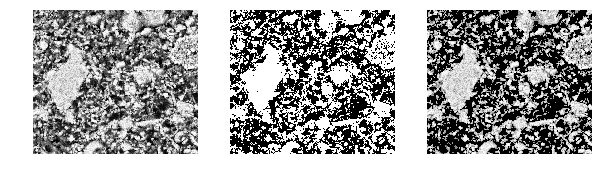

In [9]:
binary_img = bsem_grey > threshold

plt.subplot(131)
plt.imshow(bsem_grey, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(binary_img, cmap='gray')
plt.axis('off')
plt.subplot(133)
plt.imshow(bsem_grey*sem_segment(bsem_grey,threshold_low=low_mean*.95,intraporosity=3), cmap='gray')
plt.axis('off')
plt.savefig('segmentation_small.png')
plt.show()

Text(0.5,1,'Sediment Map')

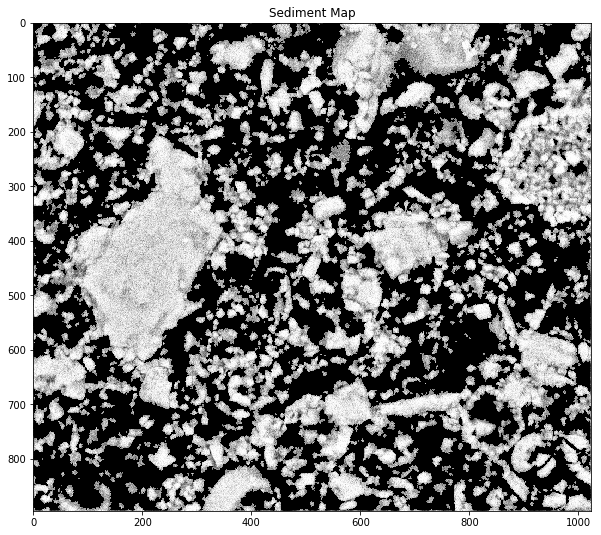

In [10]:
plt.imshow(bsem_grey*sem_segment(bsem_grey,threshold_low=low_mean*.95,intraporosity=3),cmap='gray')
plt.title('Sediment Map')

(896, 1024)

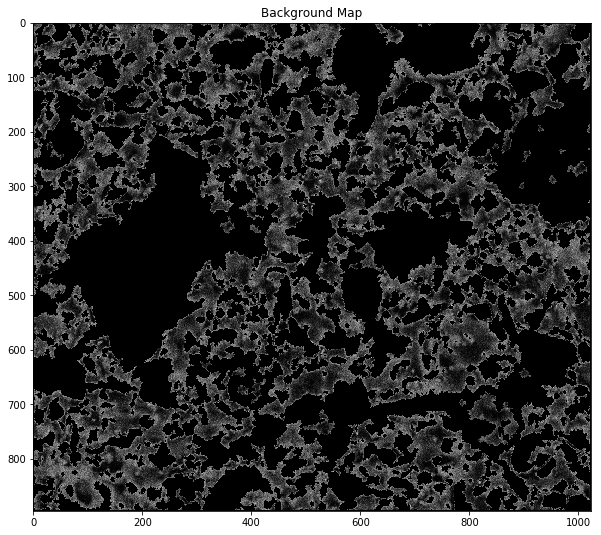

In [11]:
plt.imshow(bsem_grey*np.invert(sem_segment(bsem_grey,threshold_low=low_mean*.95)),cmap='gray')
plt.title('Background Map')
bsem_grey.shape

In [12]:
print("The porosity is {:.2f}%".format(100 * (1-(np.count_nonzero(GMM_reconstruct_final) /( GMM_reconstruct_final.shape[1] * GMM_reconstruct_final.shape[0])))))

The porosity is 45.70%


In [13]:
X = bsem_grey.reshape((bsem_grey.size, 1))
flat_classif = GaussianMixture(n_components=2,n_init=7)
flat_classif.fit(X)
x = np.array(np.linspace(0,255,896*1024)).reshape(-1,1)
Z = -flat_classif.score_samples(x)

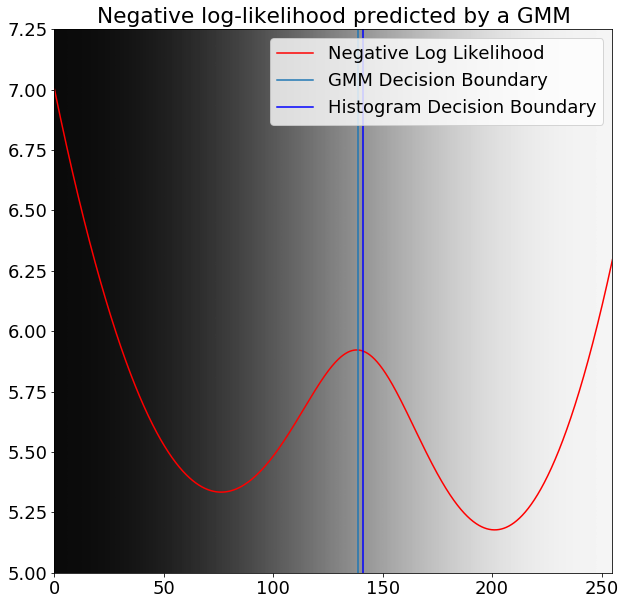

In [14]:
import matplotlib
font = {'size'   : 18}

matplotlib.rc('font', **font)

fig, ax = plt.subplots()

ax.imshow([[0,1],[0,1]], cmap=plt.cm.gray, interpolation='bicubic', extent=(0, 255, 5, 7.25), alpha=1) 

ax.plot(x, Z, 'r', label='Negative Log Likelihood')
plt.axvline(x=np.mean(classif.means_), label='GMM Decision Boundary')
plt.axvline(x=141, color='b', label='Histogram Decision Boundary')
plt.legend()
plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.savefig('GMM_decision_boundary.png', dpi = 200, bbox_inches='tight', pad_inches = 0)

In [15]:
from skimage import measure
def disk_structure(n):
    struct = np.zeros((2 * n + 1, 2 * n + 1))
    x, y = np.indices((2 * n + 1, 2 * n + 1))
    mask = (x - n)**2 + (y - n)**2 <= n**2
    struct[mask] = 1
    return struct.astype(np.bool)


def granulometry(data, sizes=None):
    s = max(data.shape)
    if sizes is None:
        sizes = range(1, s//2, 2)
    granulo = [ndimage.binary_opening(data, \
            structure=disk_structure(n)).sum() for n in sizes]
    return granulo

In [16]:
label_im, nb_labels = ndimage.label(GMM_reconstruct_final)
print("Detected {} grains.".format(nb_labels))
sizes = ndimage.sum(GMM_reconstruct_final, label_im, range(nb_labels + 1))
mean_vals = ndimage.sum(GMM_reconstruct_final, label_im, range(1, nb_labels + 1))

Detected 490 grains.


In [17]:
opened_small = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(2))
opened = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(5))
opened_more = ndimage.binary_opening(GMM_reconstruct_final, structure=disk_structure(15))

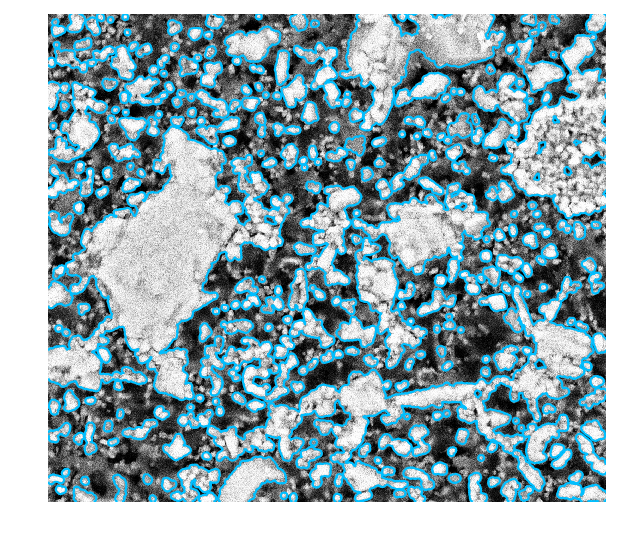

In [18]:
plt.imshow(bsem_grey, cmap=plt.cm.gray)
plt.contour(opened, [0.1], colors='deepskyblue', linewidths=2)
plt.axis('off')
plt.show()

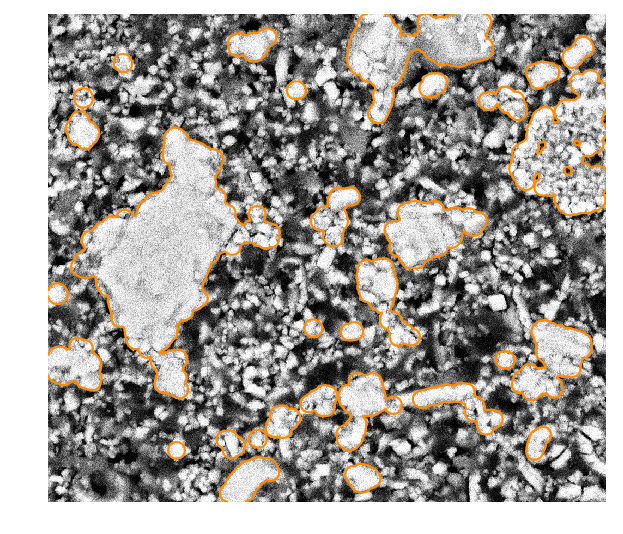

In [19]:
plt.imshow(bsem_grey, cmap=plt.cm.gray)
plt.contour(opened_more, [0.1], colors='darkorange', linewidths=2)
plt.axis('off')
plt.show()


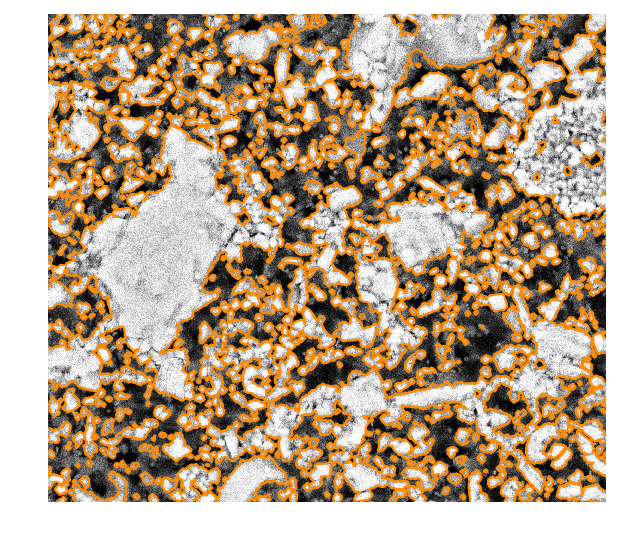

In [20]:
plt.imshow(bsem_grey, cmap=plt.cm.gray)
plt.contour(opened_small, [0.1], colors='darkorange', linewidths=2)
plt.axis('off')
plt.savefig('segmentation_small.png')
plt.show()

# Grain Calculations

In [21]:
from skimage import measure
scale = 50/1000

label_im, nb_labels = ndimage.label(opened_small)

GMM_reconstruct_final

props = measure.regionprops(label_im)

In [22]:
total_area=[]
total_diameter=[]

for p in props:
    total_area.append(p.area)
    total_diameter.append(p.equivalent_diameter)

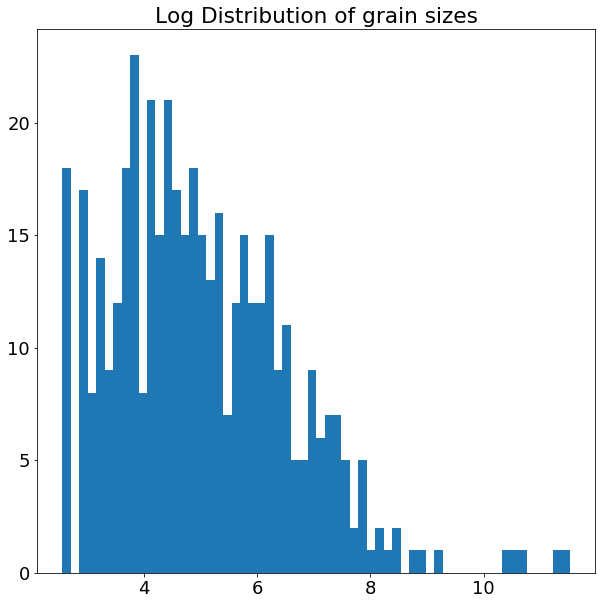

In [23]:
plt.hist(np.log(total_area),bins=60)
plt.title('Log Distribution of grain sizes')
plt.savefig('grain_sizes.png', dpi = 200, bbox_inches='tight', pad_inches = 0)

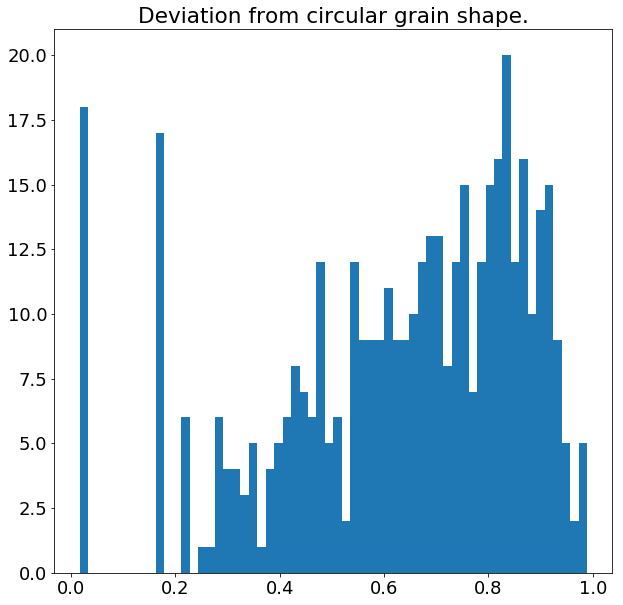

In [24]:
from math import pi
total_error = np.divide(np.subtract(total_area,np.multiply(total_diameter, pi)),total_area)
plt.hist(total_error,bins=60)
plt.title('Deviation from circular grain shape.')
plt.savefig('circ_dev.png', dpi = 200, bbox_inches='tight', pad_inches = 0)

In [25]:
peri = measure.perimeter(GMM_reconstruct_final, neighbourhood=8)
print("The perimeter is {:.3f} micrometers.".format(peri*scale))

The perimeter is 4235.111 micrometers.
